In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Data is imported from http://skyserver.sdss.org/dr16/en/tools/search/sql.aspx using SQL query

Variables: 
- objid - object id
- ra - Right Ascension
- dec - Declination
- u - u-band
- g - g-band
- r - r-band
- i - i-band
- z - z-band
- run - Run Number
- rerun - Rerun Number
- camcol - Camera column
- field - Field number
- specobjid - Object Identifier
- class - object class (galaxy, star or quasar object)
- redshift - Final Redshift
- plate - plate number
- mjd - Median Julian Date of observation
- fiberid - fiberID

In [2]:
df = pd.read_csv('sdss16.csv',header=1)

In [3]:
df

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237678877245244171,318.951692,9.315146,19.51665,18.50036,17.95667,17.53139,17.32035,7777,301,5,53,819657923239110656,GALAXY,0.114299,728,52520,10
1,1237668332026986542,217.940001,14.608378,19.13548,18.55482,17.95603,17.68272,17.63717,5322,301,3,56,6154252554903769088,QSO,1.802680,5466,56033,304
2,1237664092899115053,129.948221,25.213328,19.54955,18.19434,17.83220,17.51329,17.47054,4335,301,3,130,2173034979993348096,GALAXY,0.070813,1930,53347,175
3,1237654604252119048,160.357788,3.567886,17.72343,16.65830,16.23667,16.07098,16.02797,2126,301,1,275,649647859372681216,STAR,0.000570,577,52367,13
4,1237661360769400880,226.001700,38.619699,16.60500,15.66234,15.39406,15.29443,15.29302,3699,301,2,227,5817649714997514240,STAR,-0.000184,5167,56066,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1237661069255639209,167.169668,13.963371,18.33024,17.41838,17.14917,17.03306,16.99625,3631,301,3,336,1972663829775017984,GALAXY,0.025480,1752,53379,317
499996,1237665565001187348,225.558331,18.500700,18.73732,17.22944,16.58573,16.36947,16.26186,4678,301,1,161,3143591231423014912,STAR,-0.000060,2792,54556,286
499997,1237659119323119750,215.473064,50.610086,19.57830,18.01280,17.32779,16.90973,16.66470,3177,301,3,71,1177785077195630592,GALAXY,0.077123,1046,52460,341
499998,1237659119336554740,248.658281,31.979162,18.01998,16.62829,15.93923,15.56417,15.33296,3177,301,3,276,1508818621768427520,GALAXY,0.085555,1340,52781,410


In [4]:
df['class']=df['class'].replace(['GALAXY','STAR','QSO'],[0,1,2])

In [5]:
df["class"].value_counts()

0    252221
1    193243
2     54536
Name: class, dtype: int64

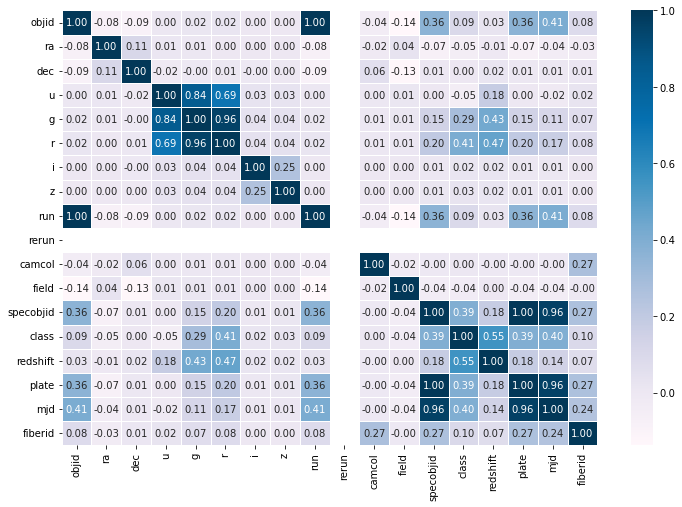

In [6]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [7]:
corr=abs(df.corr())
corr['class'].sort_values()

dec          0.000416
camcol       0.004540
i            0.020553
z            0.025509
field        0.035645
ra           0.047054
u            0.047885
run          0.094200
objid        0.094200
fiberid      0.095822
g            0.288252
specobjid    0.394010
plate        0.394010
mjd          0.398974
r            0.411350
redshift     0.551195
class        1.000000
rerun             NaN
Name: class, dtype: float64

In [8]:
df=df[['g','specobjid','plate','mjd','r','redshift','class']]

Above we find correlation between different variables and discard all the variables which are weakly correlated(<0.1) with 'class'

In [9]:
df

,g,specobjid,plate,mjd,r,redshift,class
0,18.50036,819657923239110656,728,52520,17.95667,0.114299,0
1,18.55482,6154252554903769088,5466,56033,17.95603,1.802680,2
2,18.19434,2173034979993348096,1930,53347,17.83220,0.070813,0
3,16.65830,649647859372681216,577,52367,16.23667,0.000570,1
4,15.66234,5817649714997514240,5167,56066,15.39406,-0.000184,1
...,...,...,...,...,...,...,...
499995,17.41838,1972663829775017984,1752,53379,17.14917,0.025480,0
499996,17.22944,3143591231423014912,2792,54556,16.58573,-0.000060,1
499997,18.01280,1177785077195630592,1046,52460,17.32779,0.077123,0
499998,16.62829,1508818621768427520,1340,52781,15.93923,0.085555,0


In [10]:
x = df[['g','specobjid','plate','mjd','r','redshift']]
y = df['class'].values

In [11]:
smote = SMOTE(random_state=42)
print('Original shape:', Counter(y))
x, y = smote.fit_resample(x, y)
print('Resampled shape:', Counter(y))

Original shape: Counter({0: 252221, 1: 193243, 2: 54536})
Resampled shape: Counter({0: 252221, 2: 252221, 1: 252221})


The sizes of classes are imbalanced, which may result in poor performance of classification models.
In order to fix this we use Synthetic Minority Over-Sampling Technique(SMOTE) 

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

Below we train 2 classification models: Random Forest and K Nearest Neighbors
Then we compare their results using accuracy scores and confusion matrices

In [13]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_rf = rf.predict(x_test)
rf_score = rf.score(x_test, y_test)

print('Accuracy : %.4f' % (rf_score))

Accuracy : 0.9892


In [14]:
confusion_matrix(y_test,y_rf)

array([[62452,    86,   442],
       [   61, 63086,     0],
       [ 1446,     1, 61592]])

In [15]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)
y_knn = knn.predict(x_test)
knn_score = knn.score(x_test, y_test)

print('Accuracy : %.4f' % (knn_score))

Accuracy : 0.6840


In [16]:
confusion_matrix(y_test,y_knn)

array([[45370,  4028, 13582],
       [ 8700, 46164,  8283],
       [19029,  6153, 37857]])

We can see that Random Forest is much more accurate than KNN
For Random Forest the error(objects with wrong assigned class) is very small compared to the overall sample size